### Obtained Perplexity: -7.763, Coherence: 0.2922, Best Number of Topics= 14

In [2]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2014.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [5]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [6]:
df.head()

,year,Post
0,2014,On silence and Marshawn LynchSeattle Seahawks ...
1,2014,"When You Can’t Connect, Don’t Fix It; Let The ..."
2,2014,Getting over anxiety and staying calm in the d...
3,2014,50 Seconds to Presence [+ Audio]Originally pub...
4,2014,"15 Easy Ways to Beat Anxiety NowTechnically, a..."


In [6]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [7]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [8]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['depression', 'and', 'money', 'some', 'real', 'talkdepression', 'and', 'money', 'some', 'real', 'talk', 'this', 'is', 'the', 'first', 'in', 'series', 'of', 'conversations', 'about', 'depression', 'and', 'money', 'logan', 'sachon', 'so', 'we', 're', 'here', 'today', 'to', 'talk', 'about', 'depression', 'and', 'how', 'it', 'affects', 'our', 'money', 'martha', 'kaplan', 'not', 'well', 'it', 'has', 'what', 'would', 'characterize', 'as', 'negative', 'effect', 'ls', 'yes', 'think', 'you', 'are', 'right', 'about', 'that', 'we', 'both', 'have', 'some', 'personal', 'experience', 'with', 'this', 'say', 'mk', 'would', 'say', 'that', 'also', 'ls', 'so', 'we', 're', 'going', 'to', 'talk', 'about', 'this', 'martha', 'kaplan', 'is', 'not', 'your', 'real', 'name', 'though', 'maybe', 'it', 'should', 'be', 'mk', 'yes', 'have', 'requested', 'to', 'be', 'anonymous', 'because', 'of', 'my', 'job', 'it', 'hard', 'to', 'be', 'taken', 'seriously', 'in', 'your', 'place', 'of', 'business', 'if', 'it', 'widely'

In [9]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [11]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['depression', 'and', 'money', 'some', 'real', 'talkdepression', 'and', 'money', 'some', 'real', 'talk', 'this', 'is', 'the', 'first', 'in', 'series', 'of', 'conversations', 'about', 'depression', 'and', 'money', 'logan', 'sachon', 'so', 'we', 're', 'here', 'today', 'to', 'talk', 'about', 'depression', 'and', 'how', 'it', 'affects', 'our', 'money', 'martha', 'kaplan', 'not', 'well', 'it', 'has', 'what', 'would', 'characterize', 'as', 'negative', 'effect', 'ls', 'yes', 'think', 'you', 'are', 'right', 'about', 'that', 'we', 'both', 'have', 'some', 'personal', 'experience', 'with', 'this', 'say', 'mk', 'would', 'say', 'that', 'also', 'ls', 'so', 'we', 're', 'going', 'to', 'talk', 'about', 'this', 'martha', 'kaplan', 'is', 'not', 'your', 'real', 'name', 'though', 'maybe', 'it', 'should', 'be', 'mk', 'yes', 'have', 'requested', 'to', 'be', 'anonymous', 'because', 'of', 'my', 'job', 'it', 'hard', 'to', 'be', 'taken', 'seriously', 'in', 'your', 'place', 'of', 'business', 'if', 'it', 'widely',

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [13]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

[['depression', 'money', 'real', 'talkdepression', 'money', 'real', 'talk', 'first', 'series', 'conversation', 'depression', 'money', 'logan', 'sachon', 'today', 'talk', 'depression', 'affect', 'money', 'martha', 'kaplan', 'well', 'characterize', 'negative', 'effect', 'think', 'right', 'personal', 'experience', 'say', 'mk', 'say', 'also', 'go', 'talk', 'martha', 'kaplan', 'real', 'name', 'maybe', 'mk', 'request', 'anonymous', 'job', 'hard', 'take', 'seriously', 'place', 'business', 'widely', 'know', 'lady', 'sometimes', 'trouble', 'get', 'bed', 'problematic', 'combination', 'disastrous', 'mk', 'give', 'breakdown', 'issue', 'probably', 'always', 'somewhere', 'depression', 'spectrum', 'get', 'particularly', 'bad', 'college', 'week', 'long', 'period', 'sophomore', 'year', 'really', 'leave', 'room', 'mean', 'get', 'food', 'occasionally', 'mostly', 'go', 'class', 'definitely', 'wash', 'hair', 'really', 'see', 'people', 'probably', 'part', 'shame', 'state', 'unwashed', 'hair', 'maybe', 'righ

In [21]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"worry" + 0.013*"stop" + 0.010*"thing" + 0.010*"tip" + 0.006*"happen" '
  '+ 0.006*"help" + 0.006*"great" + 0.006*"stress" + 0.006*"outcome" + '
  '0.003*"take"'),
 (1,
  '0.006*"life" + 0.006*"go" + 0.006*"say" + 0.006*"take" + 0.006*"way" + '
  '0.006*"change" + 0.006*"love" + 0.005*"see" + 0.005*"thing" + '
  '0.005*"first"'),
 (2,
  '0.015*"really" + 0.009*"college" + 0.009*"email" + 0.009*"check" + '
  '0.006*"get" + 0.006*"make" + 0.006*"anxiety" + 0.006*"friend" + '
  '0.006*"week" + 0.006*"read"'),
 (3,
  '0.033*"worry" + 0.013*"dog" + 0.008*"get" + 0.008*"life" + 0.007*"anxiety" '
  '+ 0.006*"think" + 0.006*"people" + 0.006*"still" + 0.006*"alive" + '
  '0.005*"time"'),
 (4,
  '0.004*"life" + 0.004*"human" + 0.004*"entire" + 0.004*"recommendation" + '
  '0.004*"dictate" + 0.004*"quora" + 0.004*"algorithm" + 0.004*"cycle" + '
  '0.001*"go" + 0.000*"get"'),
 (5,
  '0.015*"get" + 0.012*"thing" + 0.009*"go" + 0.009*"feel" + 0.008*"feeling" + '
  '0.008*"know" + 0.008

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.763092925014638


In [23]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2922417067498516


In [24]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [25]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.9997,"go, time, make, life, get, anxiety, feel, work...","[depression, money, real, talkdepression, mone..."
1,1,7.0,0.9992,"go, time, make, life, get, anxiety, feel, work...","[alone, scared, paris, airport, teach, alone, ..."
2,2,5.0,0.7539,"get, thing, go, feel, feeling, know, wall, din...","[ok, process, accept, statebee, ok, ok, proces..."
3,3,10.0,0.9994,"back, experience, get, time, take, work, anxie...","[judge, diversity, workbee, judge, diversity, ..."
4,4,10.0,0.9980,"back, experience, get, time, take, work, anxie...","[denver, bind, roadtrip, denver, bind, roadtri..."


In [26]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.9997,"go, time, make, life, get, anxiety, feel, work...","[depression, money, real, talkdepression, mone..."
1,1,7.0,0.9992,"go, time, make, life, get, anxiety, feel, work...","[alone, scared, paris, airport, teach, alone, ..."
2,2,5.0,0.7539,"get, thing, go, feel, feeling, know, wall, din...","[ok, process, accept, statebee, ok, ok, proces..."
3,3,10.0,0.9994,"back, experience, get, time, take, work, anxie...","[judge, diversity, workbee, judge, diversity, ..."
4,4,10.0,0.9980,"back, experience, get, time, take, work, anxie...","[denver, bind, roadtrip, denver, bind, roadtri..."
5,5,1.0,0.9990,"life, go, say, take, way, change, love, see, t...","[change, rapid, recovery, gradualchange, rapid..."
6,6,2.0,0.9955,"really, college, email, check, get, make, anxi...","[april, leggyapril, leggy, college, turn, imag..."
7,7,7.0,0.9995,"go, time, make, life, get, anxiety, feel, work...","[cure, anxietyhow, cure, anxiety, first, panic..."
8,8,10.0,0.9991,"back, experience, get, time, take, work, anxie...","[reflect, projecting, projection, happen, comm..."
9,9,4.0,0.9470,"life, human, entire, recommendation, dictate, ...","[entire, human, life, cycle, dictate, quora, r..."


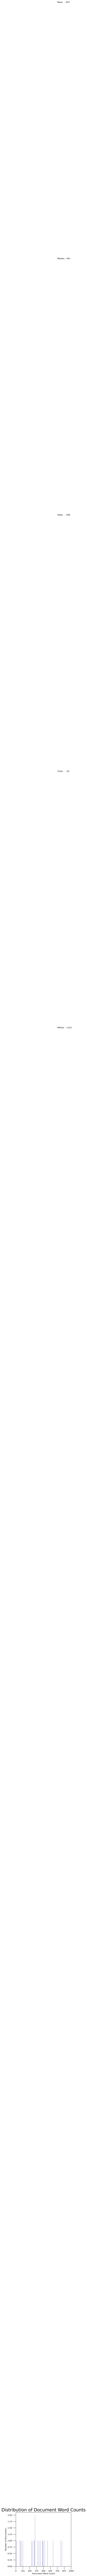

In [29]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

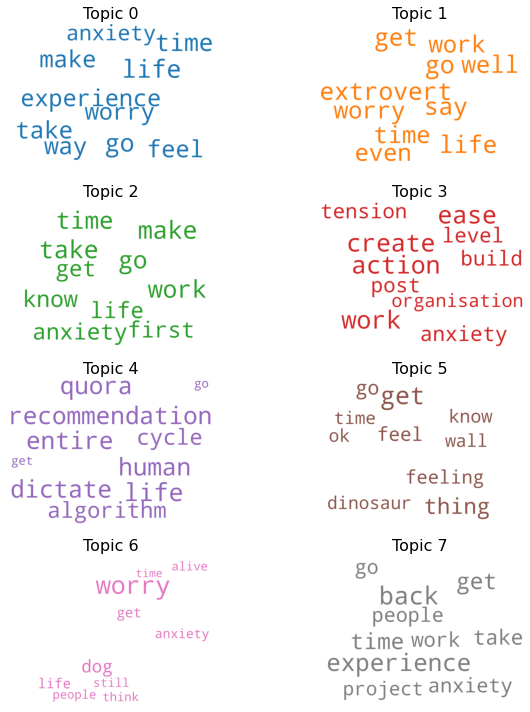

In [27]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [28]:
df_dominant_topic.to_csv("Results/Medium2014.csv")

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=20, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=6)

(14, 0.01536969302928659, 0.24845198324019138)

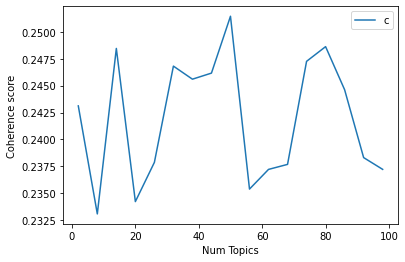

In [19]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)